In [ ]:
import pandas as pd
import os
import random
import chardet
import requests
import json
import numpy as np
from urllib3.util.retry import Retry
import openai
from requests.adapters import HTTPAdapter
import os
import pickle
import matplotlib.pyplot as plt
from utils.read_group_danmu import read_group_danmu

### Cross-language

In [ ]:
def read_scores(file, language='Chinese'):
    file_name = file.split('.')[0]
    with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-BilingualAnimes\Processed_danmu\%s\danmu_%s_downsample.pkl' % (language, file_name), 'rb') as f:
        danmu_dict = pickle.load(f)
    time_ranges = danmu_dict['%s_time_range' % file]
    
    time_points = np.zeros(len(time_ranges))
    for i in range(len(time_points)):
        time_points[i] = np.mean(time_ranges[i])

    datadir = os.path.join(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-BilingualAnimes\Emotion_scores', language, file_name)
    file_names2 = os.listdir(datadir)
    n_files = len(file_names2)
    # if n_files != seg_count:
    #     Warning('The number of files is not equal to segment counts!')
    #     print('n_files:', n_files, 'seg_count:', seg_count)
    scores_all = np.zeros((n_files, 6))
    for count in range(n_files):
        # print(count)
        file_score = '%.3f_%.3f.json' % (time_ranges[count][0], time_ranges[count][1])
        with open(os.path.join(datadir, file_score), 'r', encoding='utf-8') as file_score:
            data = json.load(file_score)            

        # 提取 "content" 字段中的文本
        content = data['choices'][0]['message']['content']

        # 解析文本，将情绪评分提取到列表中
        if language=='Chinese':
            emotions = ["高兴", "惊讶", "悲伤", "愤怒", "厌恶", "恐惧"]
        elif language=='Japanese':
            emotions = ["嬉しさ", "驚き", "悲しみ", "怒り", "嫌悪", "恐れ"]
        scores = []

        # 拆分 content 字符串，并提取每个情绪的评分
        for emotion in emotions:
            start = content.find(emotion) + len(emotion) + 2
            end = content.find(";", start)
            if end == -1:  # 最后一个情绪评分后没有分号
                end = len(content)
            # score = int(content[start:end].strip().rstrip('.'))
            # score = int(content[start:end].strip())
            try:
                score = float(content[start:end].strip())
            except:
                if content[start] == '[':
                    score = float(content[start+1:end-1].strip())
                else:
                    score = float(content[start:end].strip()[:-1])
            scores.append(score)
            
        scores_all[count] = np.array(scores)
        
    return scores_all, time_points, time_ranges

def smooth_scores(preds, time_points, smooth_win=10):
    half_win = int(round(smooth_win/2))
    preds_smoothed = np.zeros(preds.shape)
    for i in range(preds.shape[0]):
        preds_smoothed[i,:] = np.mean(preds[abs(time_points[:preds.shape[0]] - time_points[:preds.shape[0]][i]) <= half_win, :], axis=0)
    return preds_smoothed

def smooth_scores_resample(preds, time_points, smooth_win=10, resample_fs=2):
    half_win = int(round(smooth_win/2))
    resample_times = np.arange(0, np.ceil(np.max(time_points)), resample_fs)
    preds_smoothed = np.zeros((len(resample_times), preds.shape[1]))
    for i in range(len(resample_times)):
        if np.sum(abs(time_points - resample_times[i]) <= half_win)==0:
            preds_smoothed[i,:] = preds_smoothed[i-1,:]
        else:
            if len(preds[abs(time_points - resample_times[i]) <= half_win, :].shape) == 1:
                preds_smoothed[i,:] = np.mean(preds[abs(time_points - resample_times[i]) <= half_win, :].unsqueeze(0), axis=0)
            else:
                preds_smoothed[i,:] = np.mean(preds[abs(time_points - resample_times[i]) <= half_win, :], axis=0)
    return preds_smoothed, resample_times
        

def plot_scores(preds_smoothed, time_points):
    colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
    emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]

    plt.figure(figsize=(15, 12))
    for j in range(6):
        plt.subplot(6,1,j+1)
        plt.plot(time_points[:preds_smoothed.shape[0]], preds_smoothed[:,j], color=colors[j], linewidth=0.7)
        plt.xlim([0,max(time_points)])
        plt.ylim([0,7])
        plt.ylabel('Scores')
        plt.xlabel('Time/s')
        plt.title(emos[j])

    # 调整布局
    plt.tight_layout()
    # plt.savefig('figures/prompt_v4_gpt4o_longMovie_lineplot.jpg', dpi=300)
    plt.show()
    

def plot_scores2(preds_smoothed, preds_smoothed2):
    colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
    emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]

    vertical_gap_small = 0.001
    vertical_gap_large = 0.1
    height = 0.056
    left1 = 0.05
    right1 = 0.97
    width = right1 - left1

    fig = plt.figure(figsize=(8, 6))

    for j in range(6):
        bottom1 = 1 - (j+1)*height*2 - j*vertical_gap_large
        bottom2 = bottom1 + height
        R = np.corrcoef(preds_smoothed[:,j], preds_smoothed2[:,j])[0,1]
        
        ax1 = fig.add_axes([left1, bottom2, width, height])
        ax1.plot(np.arange(preds_smoothed.shape[0])*2, preds_smoothed[:, j], color=colors[j], linewidth=0.7)
        ax1.set_ylim([0, 7])
        ax1.set_xlim([0,preds_smoothed.shape[0]*2])
        ax1.set_title(emos[j]+' (R = %.3f)' % R, fontsize=13)
        ax1.set_yticks([0,4], [0,4], fontsize=10)
        ax1.set_xticks([])
        ax1.set_ylabel('Chinese', fontsize=10, rotation=0, labelpad=25)
        ax1.yaxis.label.set_position((0, 0.3))
        
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        
        ax2 = fig.add_axes([left1, bottom1, width, height])
        ax2.plot(np.arange(preds_smoothed.shape[0])*2, preds_smoothed2[:, j], color=colors[j], linewidth=0.7)
        ax2.set_ylim([0, 7])
        ax2.set_xlim([0,preds_smoothed.shape[0]*2])
        # ax2.set_title(emos[j], fontsize=15)
        ax2.set_yticks([0,4], [0,4], fontsize=10)
        ax2.set_xticks([])
        ax2.set_ylabel('Japanese', fontsize=10, rotation=0, labelpad=25)
        ax2.yaxis.label.set_position((0, 0.3))
        
        ax2.spines['right'].set_visible(False)
        # ax2.spines['top'].set_visible(False)
        
    ax2.set_xlabel('Time/s', fontsize=12)
    ax2.set_xticks(np.arange(0,preds_smoothed.shape[0]*2,500), np.arange(0,preds_smoothed.shape[0]*2,500), fontsize=12)

    plt.tight_layout()
    # plt.savefig('figures/prompt_v4_gpt3_5_turbo_Chin_Japa_lineplot_aligned.jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# 未删减：Episode 1, 2, 12, 13

cut_indices = {}
cut_indices[1] = [np.arange(9*60+58, 10*60+8), 0]
cut_indices[2] = [np.arange(16*60+50, 16*60+60), 0]
cut_indices[3] = [np.arange(18*60+28, 19*60+15), 8]
cut_indices[4] = [np.arange(22*60+11, 22*60+41), 9]
cut_indices[5] = [np.arange(11*60+37, 12*60+1), 3]
cut_indices[6] = [np.arange(14*60+26, 14*60+28), 10]
cut_indices[7] = [np.arange(0*60+48, 0*60+57), 10]
cut_indices[8] = [np.arange(17*60+52, 17*60+56), 10]
cut_indices[9] = [np.arange(22*60+25, 22*60+47), 10]
cut_indices[10] = [np.arange(16*60+37, 17*60+39), 12]
cut_indices[11] = [np.arange(19*60+46, 19*60+57), 15]
# Episode 1
# 09:58 往后10秒画面异常

# Episode 2
# 16:50 往后10秒画面异常

# Episode 4
# 22:11 往后删减
# Japanese: 22:50, Chinese: 22:41

# Episode 5
# 11:37 往后删减
# Japanese: 12:04, Chinese: 12:01

# Episode 6
# 14:26 往后删减
# Japanese: 14:38, Chinese: 14:28

# Episode 7
# 00:48 往后删减
# Japanese: 01:07, Chinese: 00:57

# Episode 8
# 17:52 往后删减
# Japanese: 18:06, Chinese: 17:56

# Episode 9
# 22:25 往后删减
# 22:32, 22:27
# Japanese: 22:57, Chinese: 22:47

# Episode 10
# 16:37后开始有剪辑
# Japanese: 17:51, Chinese: 17:39

# Episode 11
# 19:46 往后删减
# Japanese: 20:12, Chinese: 19:57

Episode 1 1406


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


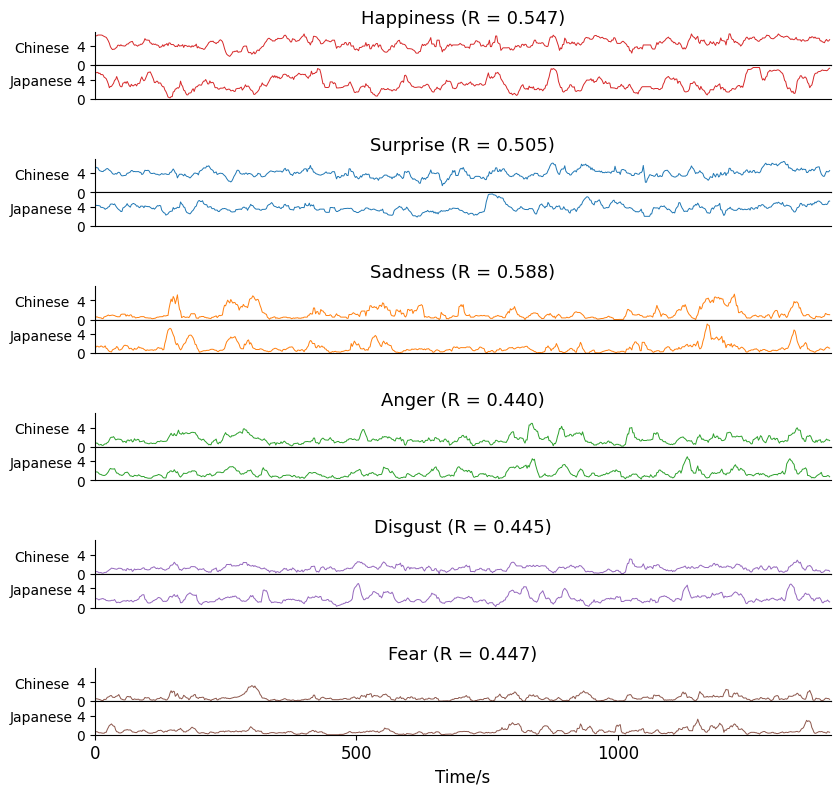

Episode 2 1404


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


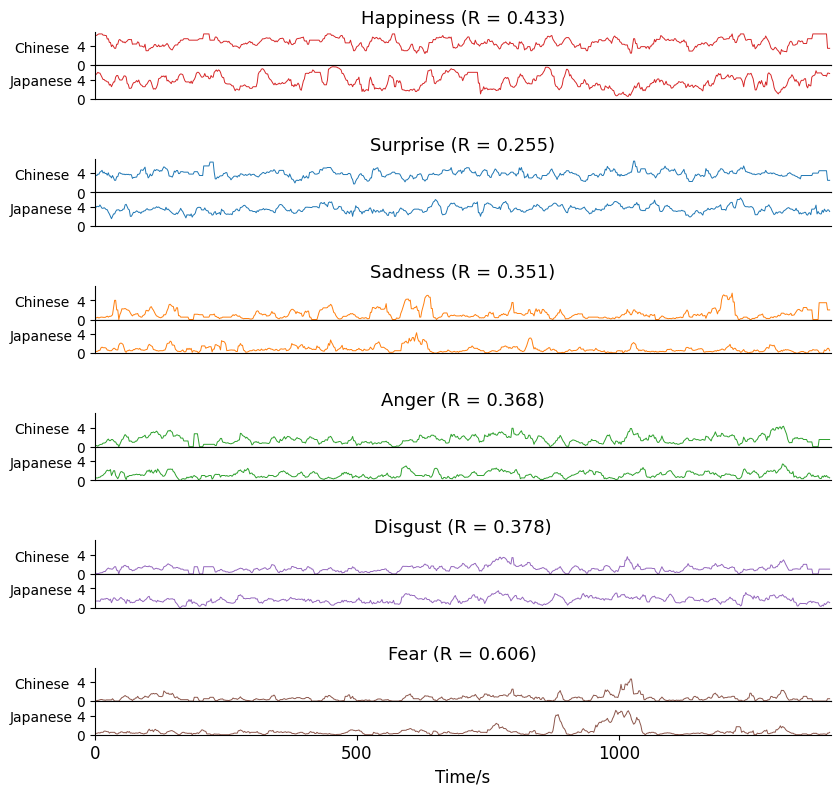

Episode 3 1392


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


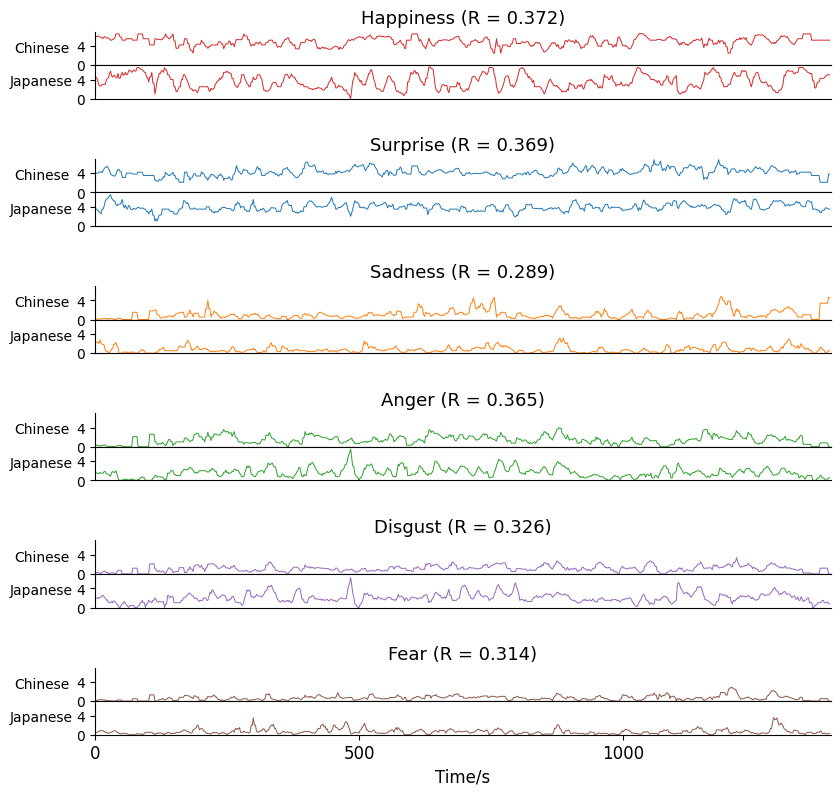

Episode 4 1400


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


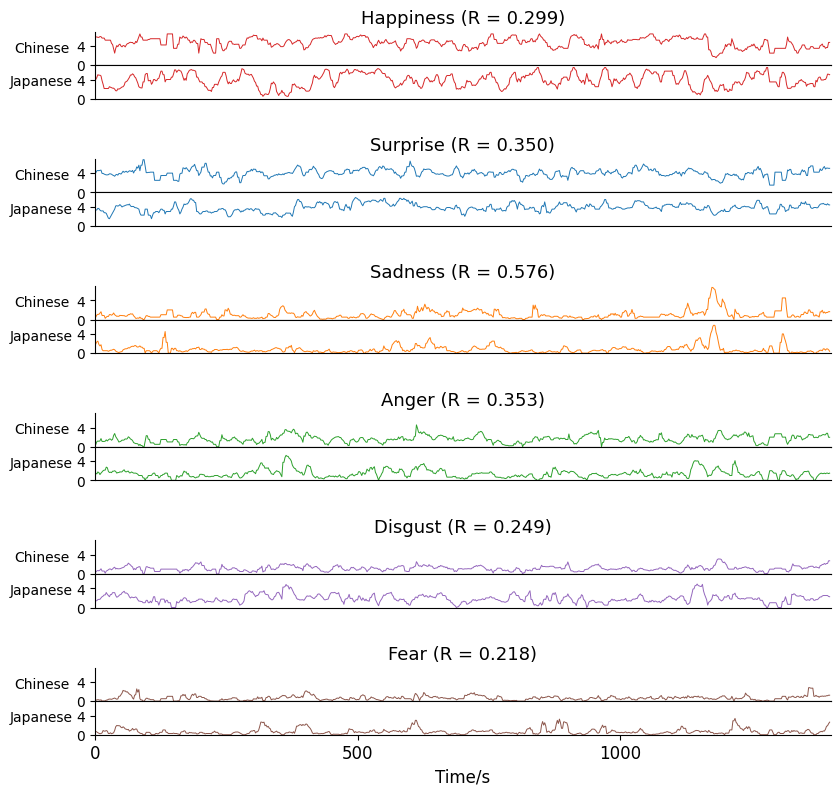

Episode 5 1398


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


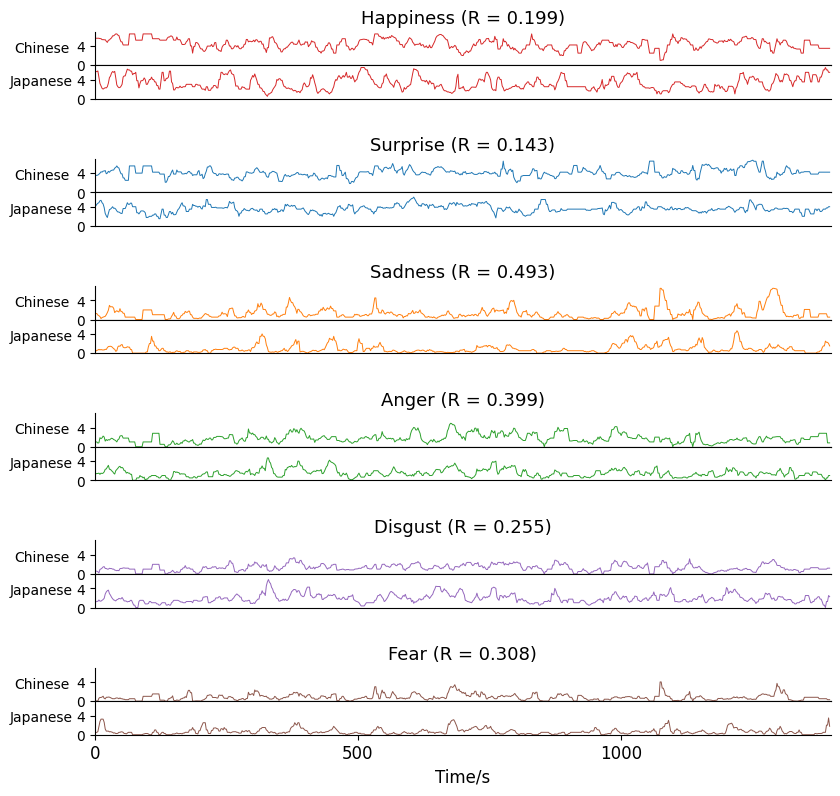

Episode 6 1396


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


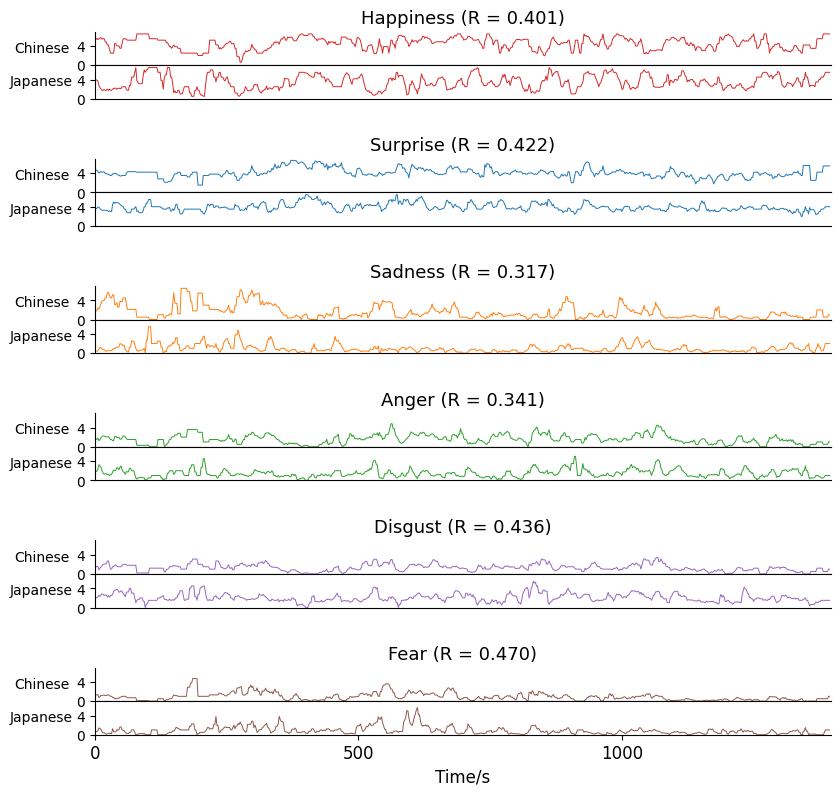

Episode 7 1398


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


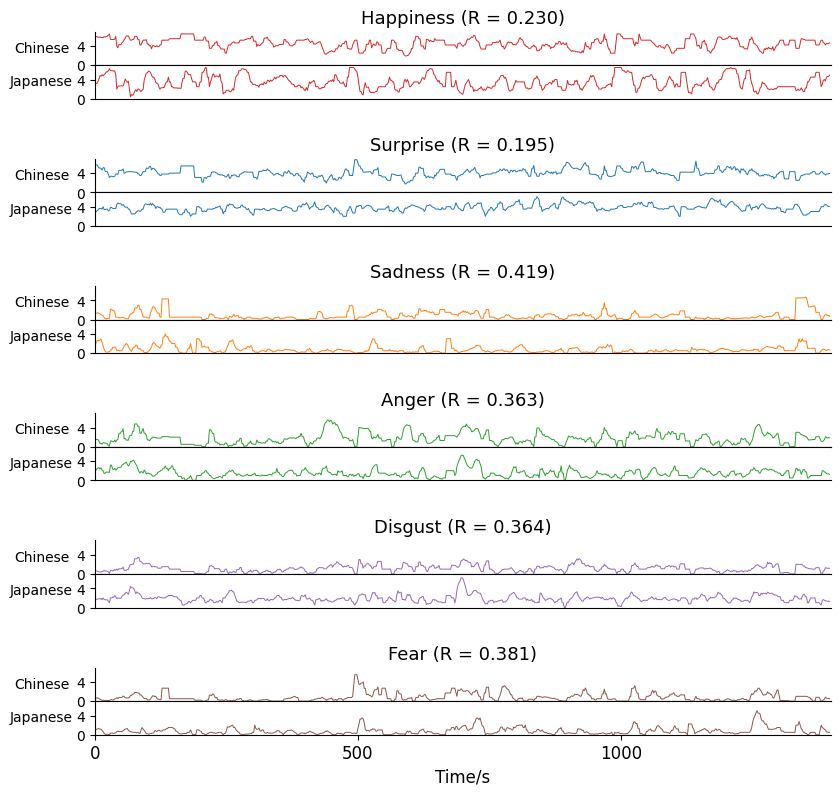

Episode 8 1418


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


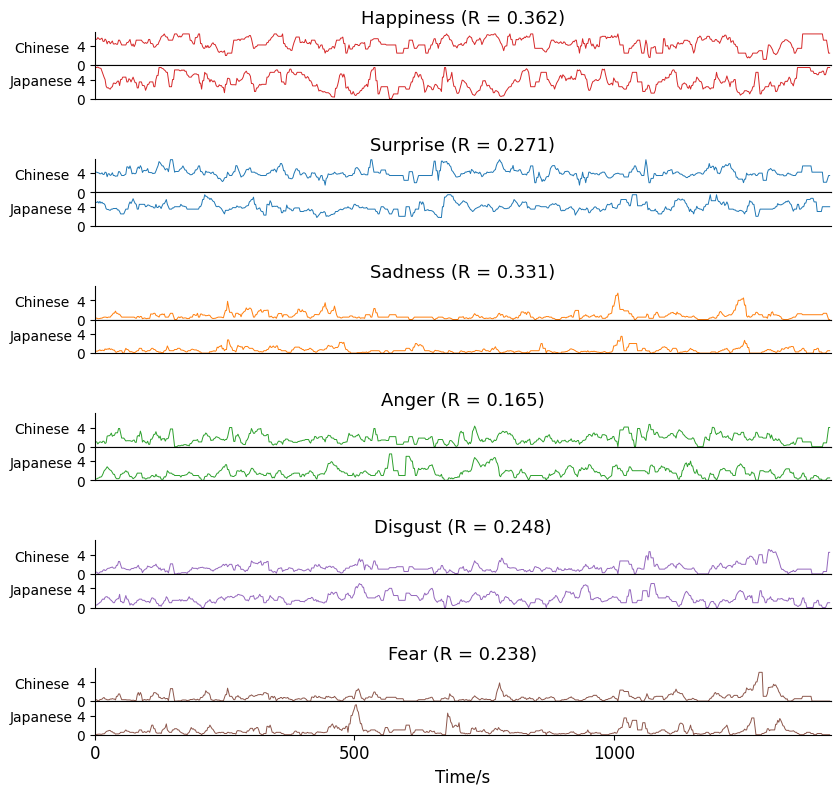

Episode 9 1400


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


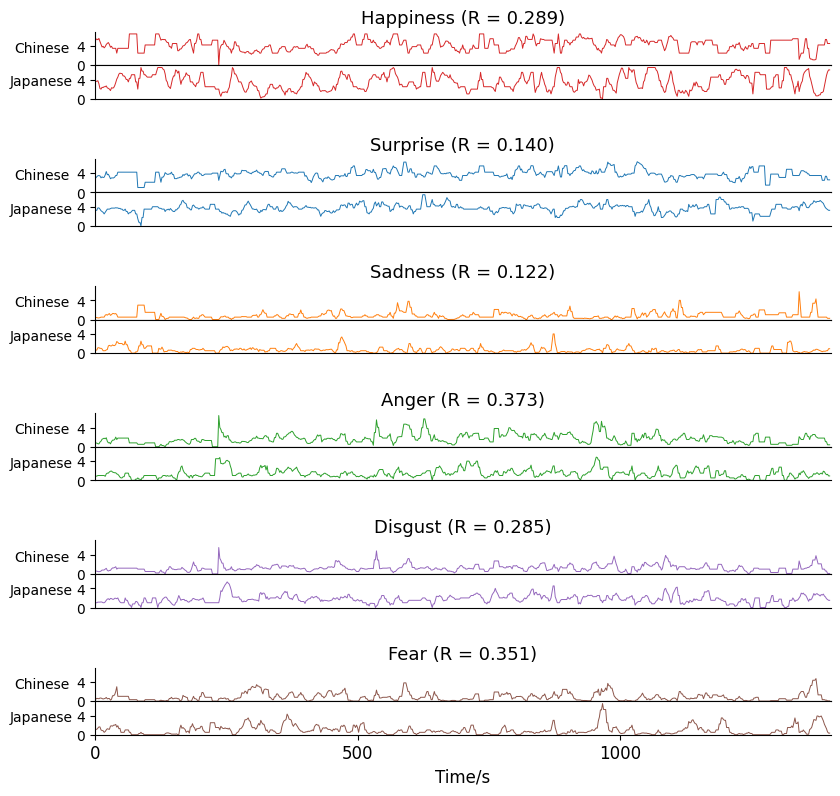

Episode 10 1396


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


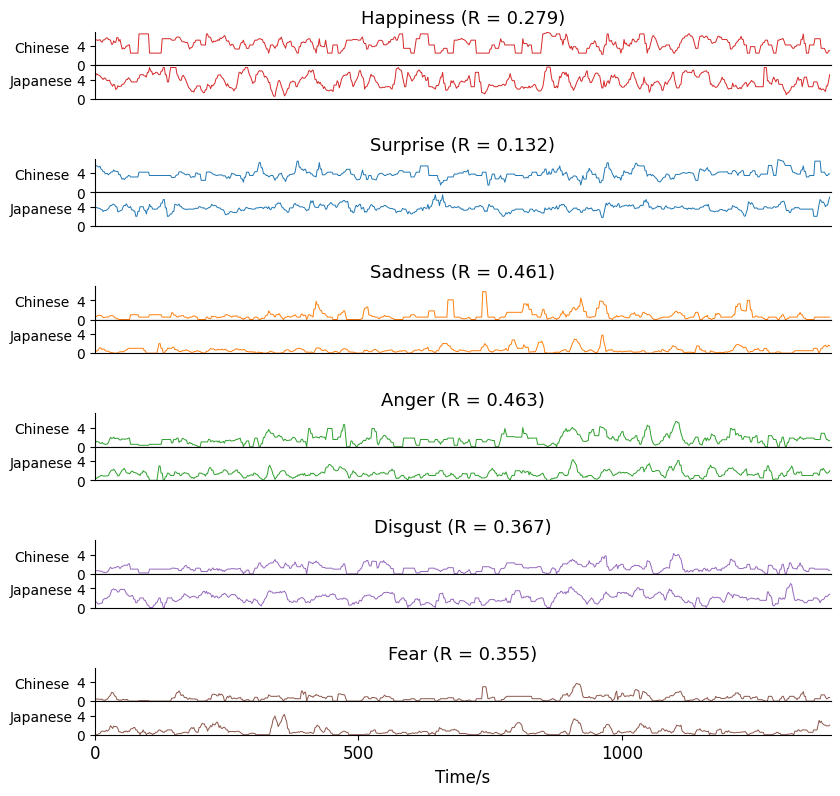

Episode 11 1388


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


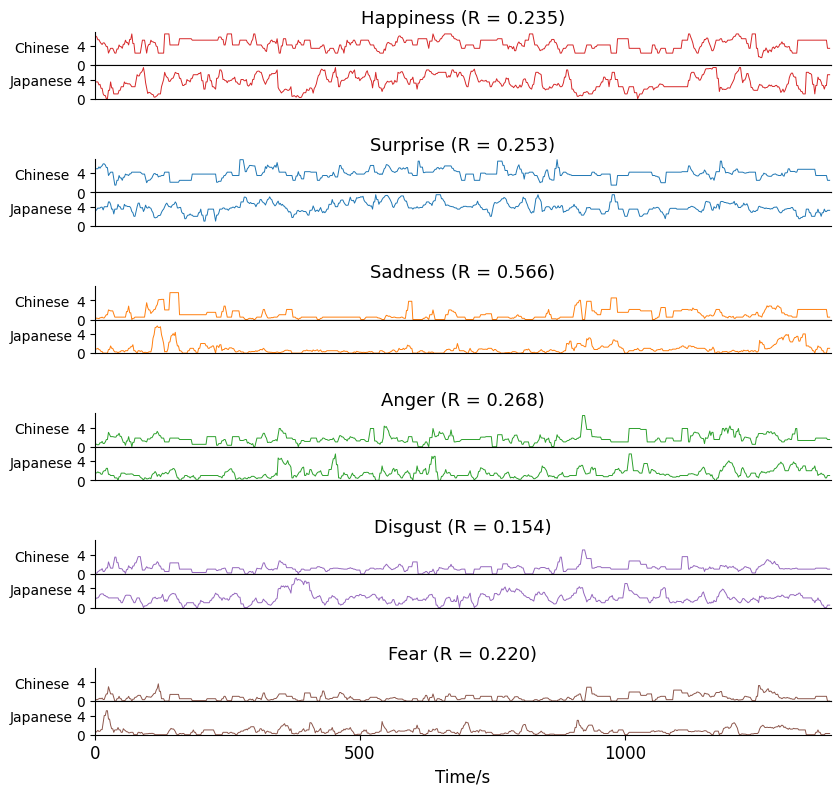

Episode 12 1440


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


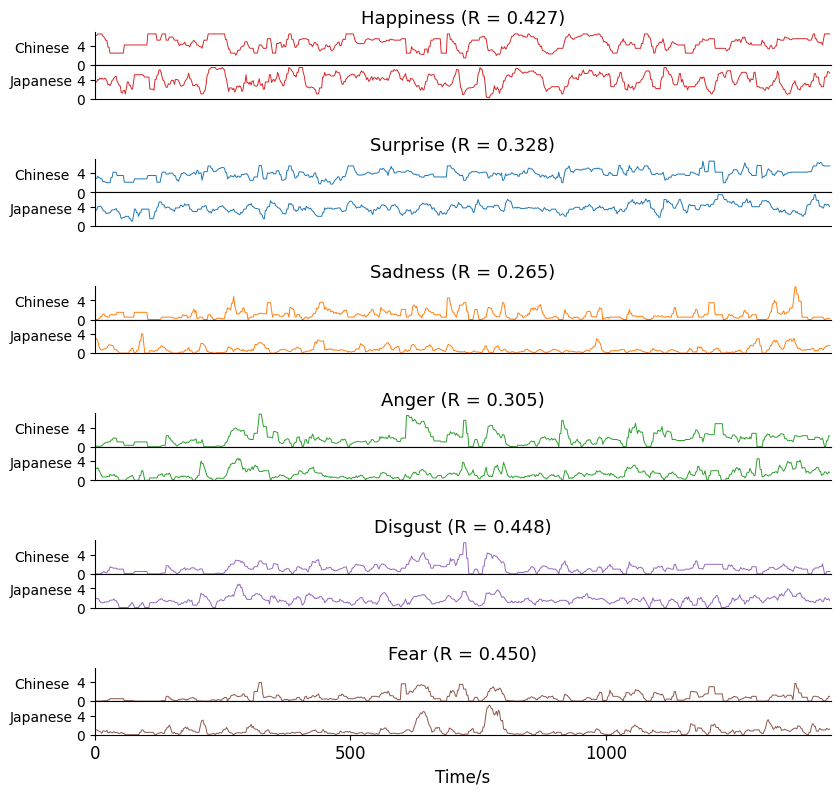

Episode 13 1442


C:\Users\Windows\AppData\Local\Temp\ipykernel_46044\3865121553.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


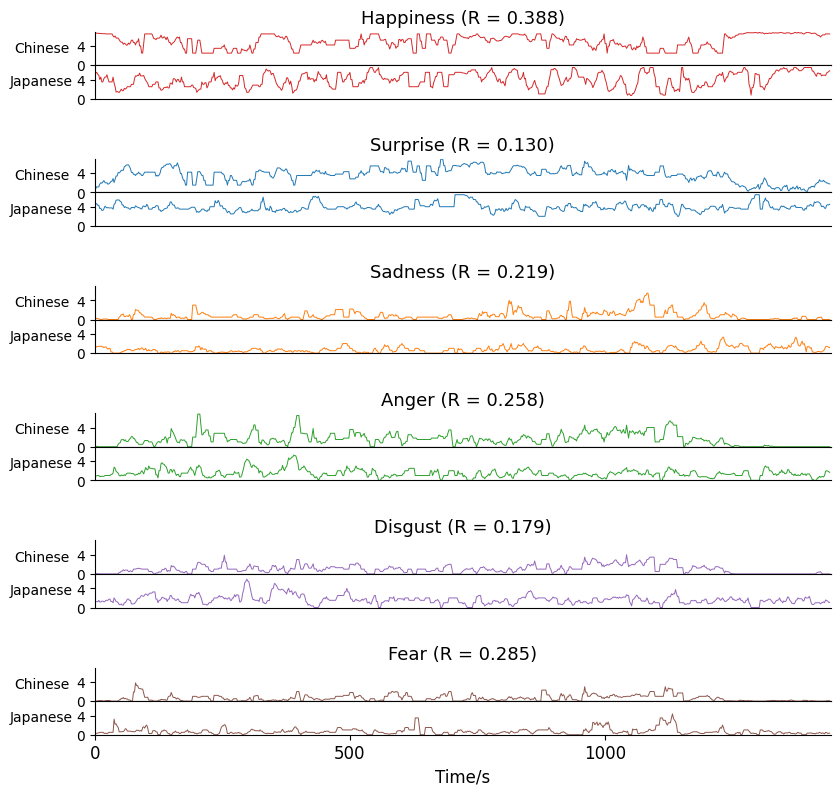

mean
[0.34317825 0.26859511 0.38431031 0.34316646 0.31797727 0.35719032]
Overall


In [ ]:
preds_smoothed_chin = np.zeros((0,6))
preds_smoothed_japa = np.zeros((0,6))
rs = np.zeros((13,6))
seg_lens = []
for i in range(1,14):
    scores_all, time_points, time_ranges = read_scores('Episode%d.csv' % i)
    preds_smoothed, resample_times = smooth_scores_resample(scores_all, time_points)
    # plot_scores(preds_smoothed, resample_times)

    scores_all2, time_points2, time_ranges2 = read_scores('Uncle_from_Another_World_ep_%d_comment.csv' % i, language='Japanese')
    preds_smoothed2, resample_times2 = smooth_scores_resample(scores_all2, time_points2)
    
    if i in np.arange(1,12):
        cut_range = cut_indices[i][0]
        cut_len = cut_indices[i][1]
        preds_smoothed = np.concatenate((preds_smoothed[:(cut_range[0]-5)//2], preds_smoothed[(cut_range[1]+5)//2:]), 0)
        resample_times = np.concatenate((resample_times[:(cut_range[0]-5)//2], resample_times[(cut_range[1]+5)//2:]), 0)
        preds_smoothed2 = np.concatenate((preds_smoothed2[:(cut_range[0]-5)//2], preds_smoothed2[(cut_range[1]+cut_len+5)//2:]), 0)
        resample_times2 = np.concatenate((resample_times2[:(cut_range[0]-5)//2], resample_times2[(cut_range[1]+cut_len+5)//2:]), 0)
    
    preds_smoothed2 = preds_smoothed2[:preds_smoothed.shape[0]]
    resample_times2 = resample_times2[:preds_smoothed.shape[0]]
    print('Episode', i, preds_smoothed.shape[0]*2)
    
    preds_smoothed_chin = np.concatenate((preds_smoothed_chin, preds_smoothed), axis=0)
    preds_smoothed_japa = np.concatenate((preds_smoothed_japa, preds_smoothed2), axis=0)

    for k in range(6):
        rs[i-1,k] = np.corrcoef(preds_smoothed[:,k], preds_smoothed2[:,k])[0,1]
        
    plot_scores2(preds_smoothed, preds_smoothed2)
    seg_lens.append(preds_smoothed.shape[0])
seg_lens = np.array(seg_lens)

print('mean')
print(np.mean(rs,axis=0))
print('Overall')
rs_overall = np.zeros(6)
for i in range(6):
    rs_overall[i] = np.corrcoef(preds_smoothed_chin[:,i], preds_smoothed_japa[:,i])[0,1]

In [ ]:
from scipy import stats
for i in range(6):
    result = stats.pearsonr(preds_smoothed_chin[:,i], preds_smoothed_japa[:,i])
    print(result)

PearsonRResult(statistic=np.float64(0.3486244853992832), pvalue=np.float64(1.8833383758619576e-259))
PearsonRResult(statistic=np.float64(0.25575269850797644), pvalue=np.float64(1.980816521798399e-136))
PearsonRResult(statistic=np.float64(0.42318852886135777), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.32480379762961203), pvalue=np.float64(1.6212079868636706e-223))
PearsonRResult(statistic=np.float64(0.30637922862403394), pvalue=np.float64(7.303357879221534e-198))
PearsonRResult(statistic=np.float64(0.3724306959091376), pvalue=np.float64(1.2377369253772185e-298))


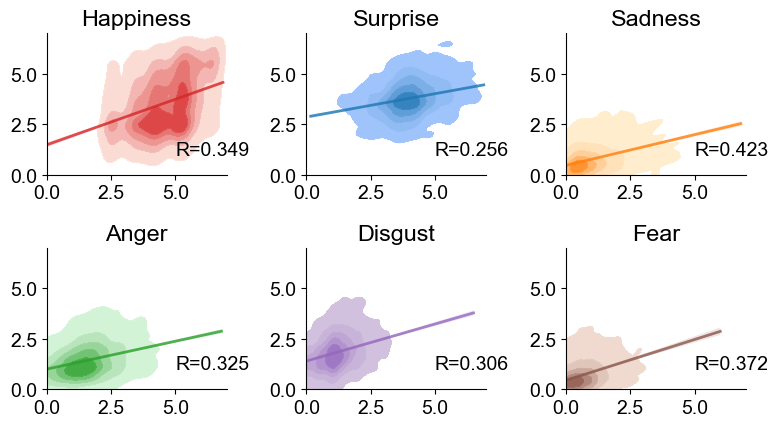

In [ ]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
gradients = [
    LinearSegmentedColormap.from_list('grad1', ['#FFF0E9', colors[0]]),  # Red
    LinearSegmentedColormap.from_list('grad2', ['#A6C8FF', colors[1]]),  # Blue
    LinearSegmentedColormap.from_list('grad3', ['#FFF1D6', colors[2]]),  # Orange
    LinearSegmentedColormap.from_list('grad4', ['#E0F9E4', colors[3]]),  # Green
    LinearSegmentedColormap.from_list('grad5', ['#D5C6E0', colors[4]]),  # Purple
    LinearSegmentedColormap.from_list('grad6', ['#F5E1D7', colors[5]])   # Brown
]

# orange_cmap = LinearSegmentedColormap.from_list('custom orange',['#FFF0E9', '#F48849'])
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 14
plt.figure(figsize=(8,4.5))
for i in range(6):
    # Concatenate preds_smoothed1 and preds_smoothed2 for each emotion
    data = np.concatenate((np.expand_dims(preds_smoothed_chin[:, i], 1), np.expand_dims(preds_smoothed_japa[:, i], 1)), 1)
    
    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['x', 'y'])  # Give columns names 'x' and 'y'
    
    ax = plt.subplot(2, 3, i + 1)
    
    # First KDE plot with filled contours
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=True, alpha=1.0, levels=6)
    
    # Second KDE plot without filling and with lines
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=False, levels=6, linewidths=0.5, alpha=0.6)
    
    sns.regplot(data=df, x='x', y='y', scatter=False, line_kws={'color': colors[i], 'lw': 2, 'alpha': 0.8})
    
    plt.title(emos[i])
    plt.xticks(np.arange(0,7,2.5))
    plt.yticks(np.arange(0,7,2.5))
    plt.xlim([0,7])
    plt.ylim([0,7])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(5,1,'R=%.3f' % rs_overall[i])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/inter_language_reliability2.svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
rs = [0.349,0.256,0.423,0.325,0.306,0.372]
print(np.mean(rs), np.std(rs))

0.3385 0.052309177015128036


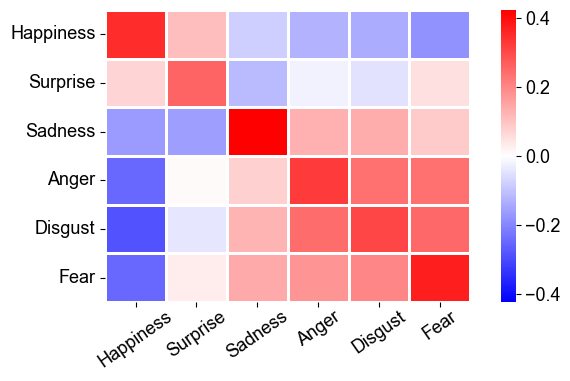

-0.734294843547277 0.734294843547277


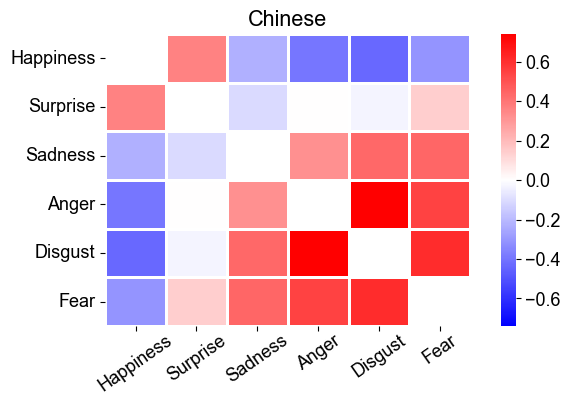

-0.638183916659502 0.638183916659502


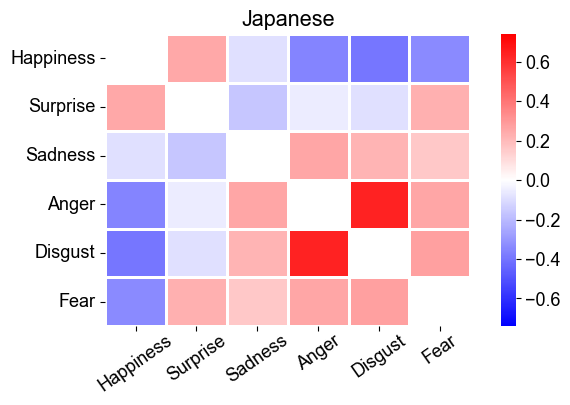

In [ ]:
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 13
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]


r_mat = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        r_mat[i,j] = np.corrcoef(preds_smoothed_chin[:,i], preds_smoothed_japa[:,j])[0,1]

# Assuming r_mat and emos are defined
fig, ax = plt.subplots(figsize=(7, 4))

vmin = -np.max(np.abs(r_mat))  # Minimum value for color scale
vmax = np.max(np.abs(r_mat))   # Maximum value for color scale

# Generate the heatmap, specifying the colormap within the heatmap call
sns.heatmap(r_mat, cmap='bwr', ax=ax, lw = 1, vmin=vmin, vmax=vmax)

# Adjust the aspect ratio
ax.set_aspect(0.8)

# Add colorbar with adjusted ticks
# cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6)
# cbar.set_ticks([-np.max(r_mat), 0.0, np.max(r_mat)])

# Set x and y ticks with rotation for x labels
plt.xticks(np.arange(0.5,6.5,1), emos, rotation=35)
ax.tick_params(axis='x', pad=0.2)
plt.yticks(np.arange(0.5,6.5,1), emos, rotation=0)

# Set color limits (clim) for the heatmap
# ax.set_clim(-np.max(np.abs(r_mat)), np.max(np.abs(r_mat)))

# Adjust the layout and save the figure
plt.tight_layout()
# plt.savefig('figures/r_mat_japa_chin.svg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

r_mat_chin = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        r_mat_chin[i,j] = np.corrcoef(preds_smoothed_chin[:,i], preds_smoothed_chin[:,j])[0,1]
    r_mat_chin[i,i] = np.nan
    
# Assuming r_mat and emos are defined
fig, ax = plt.subplots(figsize=(7, 4))

vmin = -np.nanmax(np.abs(r_mat_chin))  # Minimum value for color scale
vmax = np.nanmax(np.abs(r_mat_chin))   # Maximum value for color scale
print(vmin, vmax)
# Generate the heatmap, specifying the colormap within the heatmap call
sns.heatmap(r_mat_chin, cmap='bwr', ax=ax, lw = 1, vmin=-0.74, vmax=0.74)

# Adjust the aspect ratio
ax.set_aspect(0.8)

# Add colorbar with adjusted ticks
# cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6)
# cbar.set_ticks([-np.max(r_mat), 0.0, np.max(r_mat)])

# Set x and y ticks with rotation for x labels
plt.xticks(np.arange(0.5,6.5,1), emos, rotation=35)
ax.tick_params(axis='x', pad=0.2)
plt.yticks(np.arange(0.5,6.5,1), emos, rotation=0)

# Set color limits (clim) for the heatmap
# ax.set_clim(-np.max(np.abs(r_mat)), np.max(np.abs(r_mat)))

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig('figures/r_mat_chin.svg', dpi=300, bbox_inches='tight')
plt.title('Chinese')
# Show the plot
plt.show()

r_mat_japa = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        r_mat_japa[i,j] = np.corrcoef(preds_smoothed_japa[:,i], preds_smoothed_japa[:,j])[0,1]
    r_mat_japa[i,i] = np.nan

# Assuming r_mat and emos are defined
fig, ax = plt.subplots(figsize=(7, 4))

vmin = -np.nanmax(np.abs(r_mat_japa))  # Minimum value for color scale
vmax = np.nanmax(np.abs(r_mat_japa))   # Maximum value for color scale
print(vmin, vmax)

# Generate the heatmap, specifying the colormap within the heatmap call
sns.heatmap(r_mat_japa, cmap='bwr', ax=ax, lw = 1, vmin=-0.74, vmax=0.74)

# Adjust the aspect ratio
ax.set_aspect(0.8)

# Add colorbar with adjusted ticks
# cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6)
# cbar.set_ticks([-np.max(r_mat), 0.0, np.max(r_mat)])

# Set x and y ticks with rotation for x labels
plt.xticks(np.arange(0.5,6.5,1), emos, rotation=35)
ax.tick_params(axis='x', pad=0.2)
plt.yticks(np.arange(0.5,6.5,1), emos, rotation=0)

# Set color limits (clim) for the heatmap
# ax.set_clim(-np.max(np.abs(r_mat)), np.max(np.abs(r_mat)))

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig('figures/r_mat_japa.svg', dpi=300, bbox_inches='tight')
plt.title('Japanese')
# Show the plot
plt.show()

### LLM – human consistency vs. human – human consistency 

In [ ]:
from copy import deepcopy
import pickle
import numpy as np

def align_smooth_scores(preds, time_points, smooth_win=10):
    # cut predicted scores and time_points_german into 8 runs
    cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]

    time_points_ori = deepcopy(time_points)
    time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
    time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
    time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
    time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

    # Find time points in the german version. (the frame rate was different from the original movie)
    time_points_german = time_points_ori / (25/(24000/1001))
    
    n_emos = preds.shape[1]
    preds_cut = np.zeros((0,n_emos))
    time_points_german_cut = np.zeros(0)
    for i in range(len(cut_index2)):
        preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
        time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

    # Get time of ratings in German version
    time_ratings = []
    seg_lens = [902,882,876,976,924,878,1084,676]
    for i in range(8):
        tmp = np.arange(0,seg_lens[i],2)
        if (i > 0) and (i < 7): # The first and the last runs only have one segment
            tmp = tmp + cut_index2[i*2-1][0]
            tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
        elif i == 7:
            tmp = tmp + cut_index2[i*2-1][0]
        time_ratings.extend(tmp)
        
    # Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
    preds_cut_resample = np.zeros((3599, n_emos))
    for i in range(3599):
        if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
            preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
        else:
            preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

    # Smooth the predicted scores over ts windows
    preds_smoothed = np.zeros(preds_cut_resample.shape)
    for i in range(preds_cut_resample.shape[0]):
        tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
        preds_smoothed[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    return preds_smoothed, time_ratings


def smooth_scores(preds_cut_resample, time_ratings, smooth_win=10):
    # Smooth the predicted scores over ts windows
    preds_smoothed = np.zeros(preds_cut_resample.shape)
    for i in range(preds_cut_resample.shape[0]):
        tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
        preds_smoothed[i,:] = np.mean(tmp, axis=0)
    return preds_smoothed

In [ ]:
import h5py
import pickle
import numpy as np
import os
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Online_human_ratings_danmu\ratings6_sorted_final_12sub.pkl', 'rb') as f:
    human_danmu = pickle.load(f)
    
data_keys = np.arange(0,5756,5)
# data_keys = list(human_danmu.keys())
# time_points_human_danmu = np.zeros(len(data_keys))
human_danmu_mean = np.zeros((len(data_keys), 6))
for i in range(len(data_keys)):
    # time_points_human_danmu[i] = data_keys[i]
    human_danmu_mean[i,:] = np.mean(np.array(human_danmu[data_keys[i]]), axis=1)
    
human_danmu_12 = np.zeros((1152, 6, 12))
for i in range(len(data_keys)):
    # print(data[data_keys[i]])
    for j in range(6):
        for k in range(12):
            human_danmu_12[i,j,k] = human_danmu[data_keys[i]][j][k]
            
path=r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\Lettieri-Forrest\forrest_gump_movie_italian\raw_ratings.mat'
human_movie=np.zeros([12,6,3599])
count = 0
with h5py.File(path,'r') as file:
    for item in file.items():
        # print(item[0])
        tmp = file[item[0]][:][[0,1,3,4,5,2],:] 
        human_movie[count]=tmp
        count += 1
human_movie_mean = np.mean(human_movie, axis=0)
human_movie_mean = human_movie_mean.transpose()

human_movie = human_movie.transpose([2,1,0])
    

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
llm_danmu = scores_allvideo['forrest_gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['forrest_gump.csv_time_range']

time_points_llm_danmu = np.zeros(len(time_ranges))
for i in range(len(time_points_llm_danmu)):
    time_points_llm_danmu[i] = np.mean(time_ranges[i])

time_points_human_danmu = time_points_llm_danmu[np.arange(0,5756,5)]
human_danmu_12_aligned = np.zeros((3599,6,12))
for j in range(12):
    human_danmu_12_aligned[:,:,j], _ = align_smooth_scores(human_danmu_12[:,:,j], time_points_human_danmu)
human_danmu_mean_aligned, _ = align_smooth_scores(human_danmu_mean, time_points_human_danmu)

llm_danmu_aligned, time_ratings = align_smooth_scores(llm_danmu, time_points_llm_danmu)

smooth_win=10
human_movie_aligned = np.zeros(human_movie.shape)
for j in range(12):
    human_movie_aligned[:,:,j] = smooth_scores(human_movie[:,:,j], time_ratings)
    
human_movie_mean_aligned = smooth_scores(human_movie_mean, time_ratings)

In [ ]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

def fisher_r_to_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

cmap = plt.get_cmap('bwr')

red = cmap(0.8)  
blue = cmap(0.4) 

print("Red color code (RGBA):", red)
print("Blue color code (RGBA):", blue)

red_hex = mcolors.rgb2hex(red[:3]) 
blue_hex = mcolors.rgb2hex(blue[:3])

print("Red color code (Hex):", red_hex)
print("Blue color code (Hex):", blue_hex)

Red color code (RGBA): (np.float64(1.0), np.float64(0.4), np.float64(0.4), np.float64(1.0))
Blue color code (RGBA): (np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(1.0))
Red color code (Hex): #ff6666
Blue color code (Hex): #ccccff


[3.26131400e-05 3.83262874e-01 4.28788029e-13 3.42989531e-12
 1.02977153e-11 2.04300482e-06]
U-statistic: 669.0, P-value: 0.000160767831723909
U-statistic: 467.0, P-value: 0.32889319622979984
U-statistic: 779.0, P-value: 1.1759536575815864e-07
U-statistic: 770.0, P-value: 2.3091485867754485e-07
U-statistic: 772.0, P-value: 1.9901801706023243e-07
U-statistic: 702.0, P-value: 2.3282932114863114e-05
[1.92921398e-04 3.28893196e-01 4.61829717e-07 4.61829717e-07
 4.61829717e-07 3.49243982e-05]


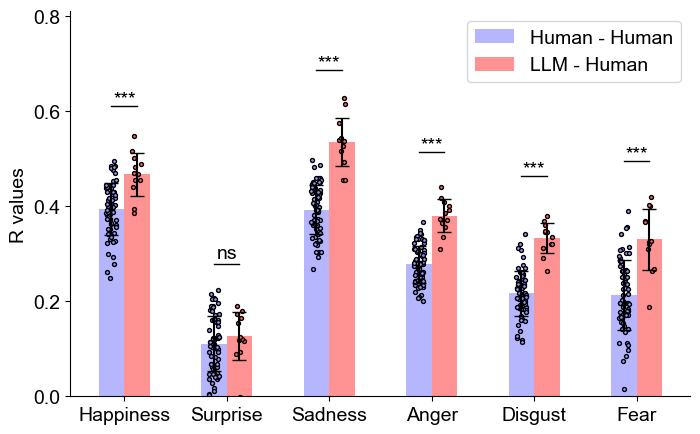

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

def fisher_r_to_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))
r_llm_human_danmu = np.zeros((6,12))
for j in range(12):
    for i in range(6):
        r_llm_human_danmu[i,j] = np.corrcoef(llm_danmu_aligned[:,i], human_danmu_12_aligned[:,i,j])[0,1]

r_human_danmu = np.zeros((6,12,12))      
for k in range(12):
    for j in range(k+1,12):
        for i in range(6):
            r_human_danmu[i,k,j] = np.corrcoef(human_danmu_12_aligned[:,i,k], human_danmu_12_aligned[:,i,j])[0,1]  
triu_inds = np.triu_indices(12,1)
# print(np.mean(r_llm_human_danmu, axis=1), np.std(r_llm_human_danmu, axis=1))
# for i in range(6):
    # print(np.mean(r_human_danmu[i,:,:][triu_inds]), np.std(r_human_danmu[i,:,:][triu_inds]))
    
ps = np.zeros(6)
for i in range(6):
    group1_z = fisher_r_to_z(r_llm_human_danmu[i,:])
    group2_z = fisher_r_to_z(r_human_danmu[i,:,:][triu_inds])
    t_stat, p_value = ttest_ind(group1_z, group2_z)
    ps[i] = p_value
    # print(t_stat, p_value)

reject, pvals_corrected, _, _ = multipletests(ps, alpha=0.05, method='fdr_bh')
print(pvals_corrected)


from scipy.stats import mannwhitneyu
# Mann-Whitney U 检验
ps = np.zeros(6)
for i in range(6):
    u_stat, p_value = mannwhitneyu(r_llm_human_danmu[i,:], r_human_danmu[i,:,:][triu_inds], alternative='two-sided')
    print(f"U-statistic: {u_stat}, P-value: {p_value}")
    ps[i] = p_value
reject, pvals_corrected, _, _ = multipletests(ps, alpha=0.05, method='fdr_bh')
print(pvals_corrected)


matplotlib.rcParams['font.family'] = 'Arial'
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

bar_width = 0.25
x = np.arange(len(emos))

fig, ax = plt.subplots(figsize=(8, 5))
# ax.bar(x, rs_llm, bar_width, label='LLM', capsize=5, color=[188./255,189./255,50./255])
r_human_danmu_vec = np.zeros((6,66))
for i in range(6):
    r_human_danmu_vec[i] = r_human_danmu[i,:,:][triu_inds]
    
ax.bar(x, np.mean(r_llm_human_danmu, axis=1), bar_width, yerr=np.std(r_llm_human_danmu, axis=1), label='LLM', capsize=5, color='#ff6666', alpha=0.7)
ax.bar(x + bar_width, np.mean(r_human_danmu_vec , axis=1), bar_width, yerr=np.std(r_human_danmu_vec, axis=1), label='Human', capsize=5, color='gray', alpha=0.4)
plt.legend(['LLM - Human','Human - Human'], fontsize=14, loc='upper right',frameon=False)
# 添加散点
for i in range(len(emos)):
    jitter_llm = np.random.uniform(-0.05, 0.05, size=r_llm_human_danmu[i, :].shape)  # 对 LLM-Human 散点添加抖动
    jitter_human = np.random.uniform(-0.05, 0.051, size=r_human_danmu[i, :, :][triu_inds].shape)  # 对 Human-Human 散点添加抖动

    # 对 Human - Human 添加散点
    ax.scatter(
        np.full_like(r_llm_human_danmu[i, :], x[i]) + jitter_llm,  # x 坐标
        r_llm_human_danmu[i, :],  # y 坐标
        color='#ff6666',
        s=8,
        edgecolor='black',  # 设置散点边框颜色
        alpha=0.7  # 设置透明度
    )
    # 对 LLM - Human 添加散点
    ax.scatter(
        np.full_like(r_human_danmu[i, :, :][triu_inds], x[i]+ bar_width ) +jitter_human ,  # x 坐标
        r_human_danmu[i, :, :][triu_inds],  # y 坐标
        color='gray',
        s=8,
        edgecolor='black',  # 设置散点边框颜色
        alpha=0.4  # 设置透明度
    )
    
    p_value = pvals_corrected[i]
    if p_value < 0.001:
        star = "***"
    elif p_value < 0.01:
        star = "**"
    elif p_value < 0.05:
        star = "*"
    else:
        star = 'ns'
    
    y_max = max(np.mean(r_llm_human_danmu[i, :]) + np.std(r_llm_human_danmu[i, :]),
                np.mean(r_human_danmu_vec[i]) + np.std(r_human_danmu_vec[i]))
    y_line = y_max + 0.1  # 横线高度
    # 添加横线
    ax.plot([x[i], x[i] + bar_width], [y_line, y_line], color='black', lw=1)

    # 添加显著性标注
    if p_value >= 0.05:
        ax.text((x[i] + x[i] + bar_width) / 2, y_line+0.005, star, ha='center', va='bottom', fontsize=14, color='black')
    else:
        ax.text((x[i] + x[i] + bar_width) / 2, y_line-0.005, star, ha='center', va='bottom', fontsize=14, color='black')


# 设置 x 轴刻度
ax.set_xticks(x + bar_width/2, emos, fontsize=14)
#ax.set_xticks([])
plt.yticks(np.arange(0,0.81,0.2), fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('R values', fontsize=14)
plt.ylim([0, 0.81])
os.makedirs('figures',exist_ok=True)
plt.savefig('figures/r_llm_human_danmu.svg', format = 'svg')
plt.show()

### Cross-model consistency

In [ ]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())
preds = scores_allvideo['forrest_gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['forrest_gump.csv_time_range']


dict_keys(['error_count_list', 'forrest_gump'])


In [ ]:
# with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_kimi.pkl', 'rb') as f:
#     scores_allvideo = pickle.load(f)
# print(scores_allvideo.keys())
# preds = scores_allvideo['forrest_gump']

# with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt4o.pkl', 'rb') as f:
#     scores_allvideo = pickle.load(f)
# scores_allvideo['forrest_gump'] = deepcopy(scores_allvideo['阿甘正传'])
# del scores_allvideo['阿甘正传']
# print(scores_allvideo.keys())
# print(scores_allvideo['forrest_gump'].shape)
# with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt4o.pkl', 'wb') as f:
#     pickle.dump(scores_allvideo, f)

# with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_deepseek.pkl', 'rb') as f:
data = np.load(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_deepseek.npy')
scores_allvideo = {}
scores_allvideo['forrest_gump'] = data
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_deepseek.pkl', 'wb') as f:
    pickle.dump(scores_allvideo, f)

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_firstHalf_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo['scores_allvideo'].keys())
print(scores_allvideo['scores_allvideo']['阿甘正传-firstHalf'].shape)
scores_allvideo['forrest_gump'] = deepcopy(scores_allvideo['scores_allvideo']['阿甘正传-firstHalf'])
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_firstHalf_gpt3_5_turbo.pkl', 'wb') as f:
    pickle.dump(scores_allvideo, f)

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_secondHalf_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo['scores_allvideo'].keys())
print(scores_allvideo['scores_allvideo']['阿甘正传-secondHalf'].shape)
scores_allvideo['forrest_gump'] = deepcopy(scores_allvideo['scores_allvideo']['阿甘正传-secondHalf'])
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_secondHalf_gpt3_5_turbo.pkl', 'wb') as f:
    pickle.dump(scores_allvideo, f)

dict_keys(['阿甘正传-firstHalf'])
(3514, 6)
dict_keys(['阿甘正传-secondHalf'])
(3697, 6)


In [ ]:
# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed1 = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed1[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    
    

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_kimi.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())
preds = scores_allvideo['forrest_gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['forrest_gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed2 = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed2[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    
rs = np.zeros(6)
for i in range(6):
    rs[i] = np.corrcoef(preds_smoothed1[:,i], preds_smoothed2[:,i])[0,1]
    

dict_keys(['error_count_list', 'forrest_gump'])


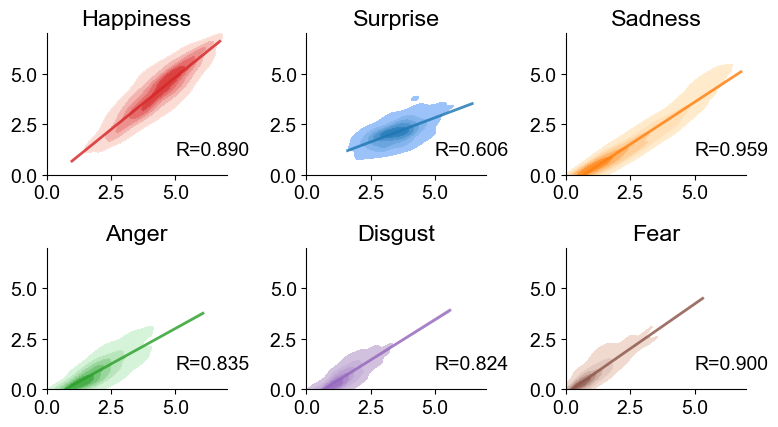

In [ ]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
gradients = [
    LinearSegmentedColormap.from_list('grad1', ['#FFF0E9', colors[0]]),  # Red
    LinearSegmentedColormap.from_list('grad2', ['#A6C8FF', colors[1]]),  # Blue
    LinearSegmentedColormap.from_list('grad3', ['#FFF1D6', colors[2]]),  # Orange
    LinearSegmentedColormap.from_list('grad4', ['#E0F9E4', colors[3]]),  # Green
    LinearSegmentedColormap.from_list('grad5', ['#D5C6E0', colors[4]]),  # Purple
    LinearSegmentedColormap.from_list('grad6', ['#F5E1D7', colors[5]])   # Brown
]

# orange_cmap = LinearSegmentedColormap.from_list('custom orange',['#FFF0E9', '#F48849'])
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 14
plt.figure(figsize=(8,4.5))
for i in range(6):
    # Concatenate preds_smoothed1 and preds_smoothed2 for each emotion
    data = np.concatenate((np.expand_dims(preds_smoothed1[:, i], 1), np.expand_dims(preds_smoothed2[:, i], 1)), 1)
    
    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['x', 'y'])  # Give columns names 'x' and 'y'
    
    ax = plt.subplot(2, 3, i + 1)
    
    # First KDE plot with filled contours
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=True, alpha=1.0, levels=6)
    
    # Second KDE plot without filling and with lines
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=False, levels=6, linewidths=0.5, alpha=0.6)
    
    sns.regplot(data=df, x='x', y='y', scatter=False, line_kws={'color': colors[i], 'lw': 2, 'alpha': 0.8})
    
    plt.title(emos[i])
    plt.xticks(np.arange(0,7,2.5))
    plt.yticks(np.arange(0,7,2.5))
    plt.xlim([0,7])
    plt.ylim([0,7])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(5,1,'R=%.3f' % rs[i])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/inter_model_reliability2.svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Cross-model consistency (supplementary)

preds_smoothed_gpt3_5 = preds_smoothed1
preds_smoothed_kimi = preds_smoothed2

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt4o.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())
preds = scores_allvideo['forrest_gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['forrest_gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed_gpt4o = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed_gpt4o[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    
    
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_deepseek.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())

preds = scores_allvideo['forrest_gump']
# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed_deepseek = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed_deepseek[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)

dict_keys(['forrest_gump'])
dict_keys(['forrest_gump'])


In [ ]:
preds_smoothed_all = {}
preds_smoothed_all['gpt3_5'] = preds_smoothed_gpt3_5
preds_smoothed_all['kimi'] = preds_smoothed_kimi
preds_smoothed_all['gpt4o'] = preds_smoothed_gpt4o
preds_smoothed_all['deepseek'] = preds_smoothed_deepseek
keys = list(preds_smoothed_all.keys())

In [ ]:
rs_cross_model = np.zeros((4,4,6))
for i in range(4):
    for j in range(i+1,4):
        for k in range(6):
            rs_cross_model[i,j,k] = np.corrcoef(preds_smoothed_all[keys[i]][:,k], preds_smoothed_all[keys[j]][:,k])[0,1]
        print(keys[i], keys[j], rs_cross_model[i,j,:])
        print(np.mean(rs_cross_model[i,j,:]), np.std(rs_cross_model[i,j,:]))

gpt3_5 kimi [0.89002856 0.60579647 0.95875703 0.834947   0.82447736 0.89972482]
0.8356218743831286 0.11193443974480008
gpt3_5 gpt4o [0.84160607 0.63534909 0.95570351 0.81903558 0.83320479 0.88188223]
0.8277968782044528 0.09714094888492585
gpt3_5 deepseek [0.82997555 0.62275746 0.95526778 0.79507912 0.75900439 0.85155167]
0.8022726629955526 0.10062552405364117
kimi gpt4o [0.9452175  0.80564231 0.95349937 0.90286638 0.88573872 0.92899649]
0.9036601277207915 0.04963566606733551
kimi deepseek [0.93601923 0.74835145 0.95639821 0.89901824 0.83102384 0.91148123]
0.8803820324004515 0.07077750485919587
gpt4o deepseek [0.94123921 0.88463336 0.96853074 0.92460403 0.88529916 0.92968001]
0.9223310862309028 0.029842867995870388


gpt3_5 kimi [0.89002856 0.60579647 0.95875703 0.834947   0.82447736 0.89972482]


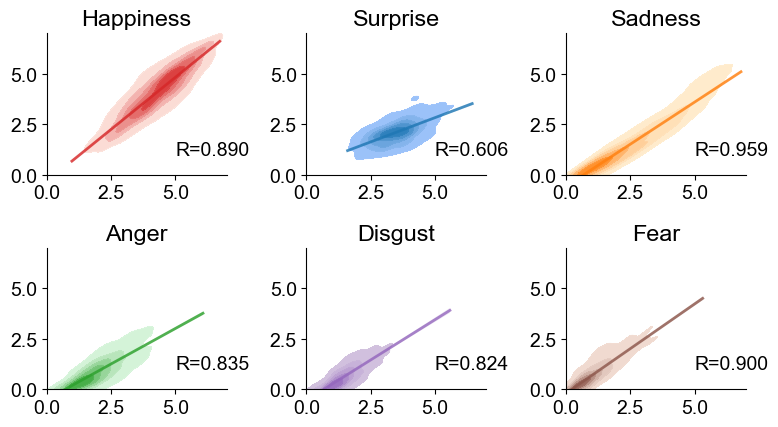

gpt3_5 gpt4o [0.84160607 0.63534909 0.95570351 0.81903558 0.83320479 0.88188223]


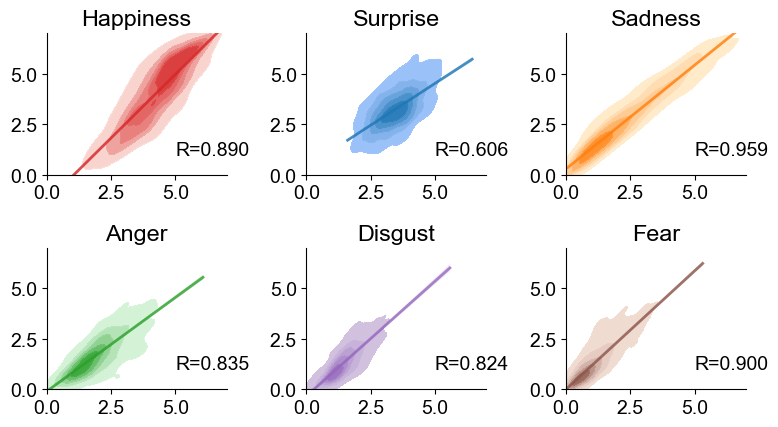

gpt3_5 deepseek [0.82997555 0.62275746 0.95526778 0.79507912 0.75900439 0.85155167]


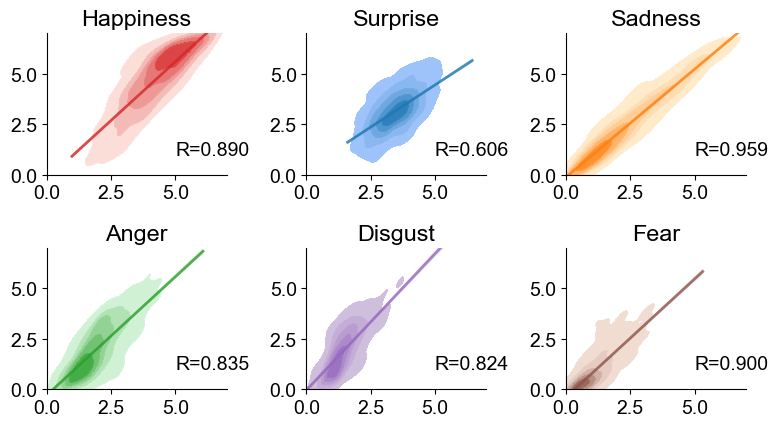

kimi gpt4o [0.9452175  0.80564231 0.95349937 0.90286638 0.88573872 0.92899649]


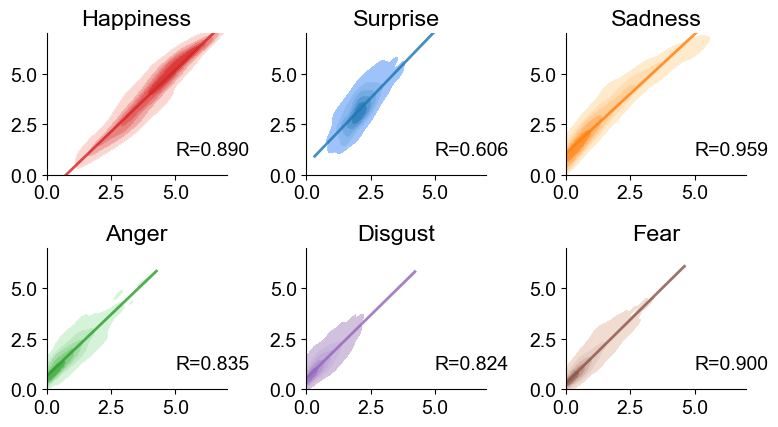

kimi deepseek [0.93601923 0.74835145 0.95639821 0.89901824 0.83102384 0.91148123]


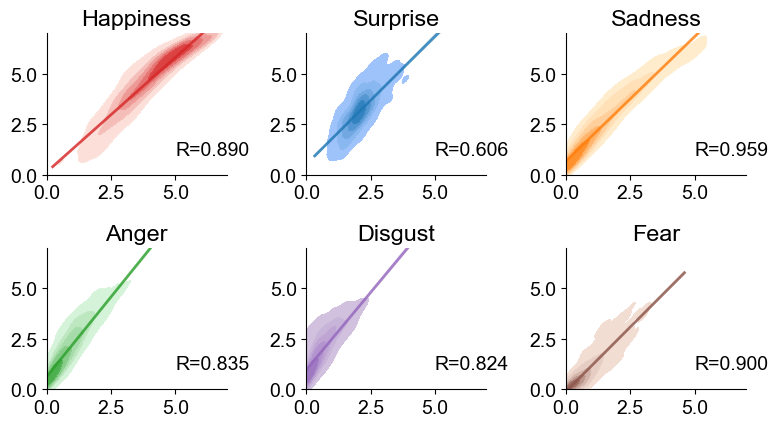

gpt4o deepseek [0.94123921 0.88463336 0.96853074 0.92460403 0.88529916 0.92968001]


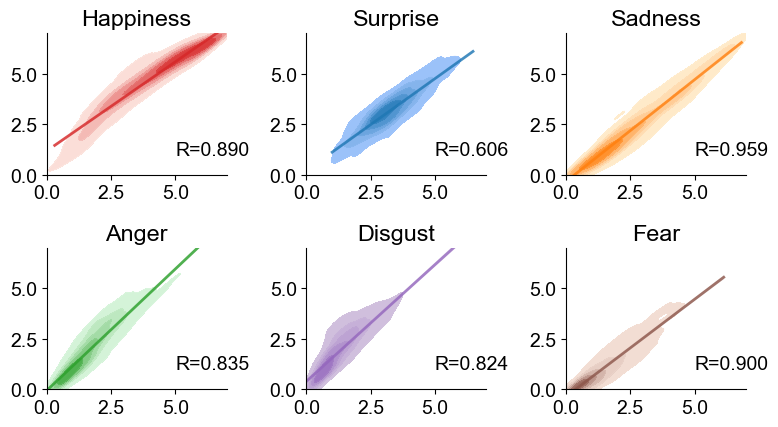

In [ ]:
for i in range(4):
    for j in range(i+1,4):
        for k in range(6):
            rs_cross_model[i,j,k] = np.corrcoef(preds_smoothed_all[keys[i]][:,k], preds_smoothed_all[keys[j]][:,k])[0,1]
        print(keys[i], keys[j], rs_cross_model[i,j,:])       
        
        plt.figure(figsize=(8,4.5))
        for k in range(6):
            # Concatenate preds_smoothed1 and preds_smoothed2 for each emotion
            data = np.concatenate((np.expand_dims(preds_smoothed_all[keys[i]][:,k], 1), np.expand_dims(preds_smoothed_all[keys[j]][:,k], 1)), 1)
            
            # Convert the numpy array to a pandas DataFrame
            df = pd.DataFrame(data, columns=['x', 'y'])  # Give columns names 'x' and 'y'
            
            ax = plt.subplot(2, 3, k + 1)
            
            # First KDE plot with filled contours
            sns.kdeplot(data=df, x='x', y='y', cmap=gradients[k], fill=True, alpha=1.0, levels=6)
            
            # Second KDE plot without filling and with lines
            sns.kdeplot(data=df, x='x', y='y', cmap=gradients[k], fill=False, levels=6, linewidths=0.5, alpha=0.6)
            
            sns.regplot(data=df, x='x', y='y', scatter=False, line_kws={'color': colors[k], 'lw': 2, 'alpha': 0.8})
            
            plt.title(emos[k])
            plt.xticks(np.arange(0,7,2.5))
            plt.yticks(np.arange(0,7,2.5))
            plt.xlim([0,7])
            plt.ylim([0,7])
            plt.xlabel('')
            plt.ylabel('')
            plt.text(5,1,'R=%.3f' % rs[k])
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

        plt.tight_layout()
        plt.savefig('figures/r_%s_%s_kde.svg' % (keys[i], keys[j]), dpi=300)
        plt.show()

### Cross-time consistency

In [ ]:
from copy import deepcopy
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_firstHalf_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())
preds = scores_allvideo['forrest_gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample_firstHalf.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['阿甘正传-firstHalf.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed1 = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed1[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    
    

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_secondHalf_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())
preds = scores_allvideo['forrest_gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample_secondHalf.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['阿甘正传-secondHalf.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed2 = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed2[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    
rs = np.zeros(6)
for i in range(6):
    rs[i] = np.corrcoef(preds_smoothed1[:,i], preds_smoothed2[:,i])[0,1]
    

dict_keys(['scores_allvideo', 'error_count_list', 'forrest_gump'])
dict_keys(['scores_allvideo', 'error_count_list', 'forrest_gump'])


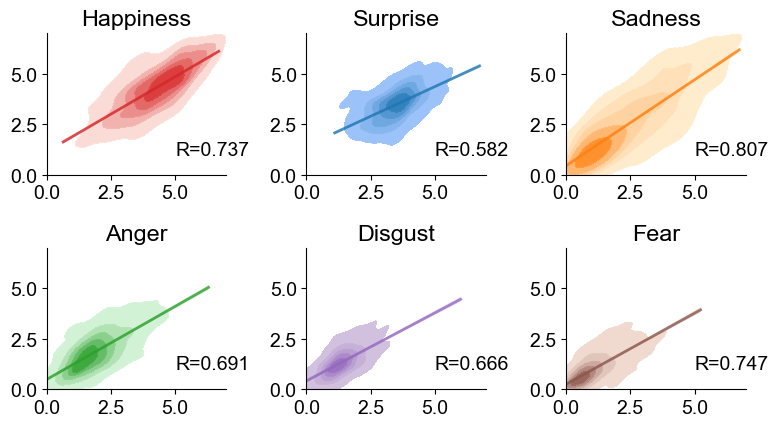

In [ ]:
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
gradients = [
    LinearSegmentedColormap.from_list('grad1', ['#FFF0E9', colors[0]]),  # Red
    LinearSegmentedColormap.from_list('grad2', ['#A6C8FF', colors[1]]),  # Blue
    LinearSegmentedColormap.from_list('grad3', ['#FFF1D6', colors[2]]),  # Orange
    LinearSegmentedColormap.from_list('grad4', ['#E0F9E4', colors[3]]),  # Green
    LinearSegmentedColormap.from_list('grad5', ['#D5C6E0', colors[4]]),  # Purple
    LinearSegmentedColormap.from_list('grad6', ['#F5E1D7', colors[5]])   # Brown
]

# orange_cmap = LinearSegmentedColormap.from_list('custom orange',['#FFF0E9', '#F48849'])
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 14
plt.figure(figsize=(8,4.5))
for i in range(6):
    # Concatenate preds_smoothed1 and preds_smoothed2 for each emotion
    data = np.concatenate((np.expand_dims(preds_smoothed1[:, i], 1), np.expand_dims(preds_smoothed2[:, i], 1)), 1)
    
    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['x', 'y'])  # Give columns names 'x' and 'y'
    
    ax = plt.subplot(2, 3, i + 1)
    
    # First KDE plot with filled contours
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=True, alpha=1.0, levels=6)
    
    # Second KDE plot without filling and with lines
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=False, levels=6, linewidths=0.5, alpha=0.6)
    
    sns.regplot(data=df, x='x', y='y', scatter=False, line_kws={'color': colors[i], 'lw': 2, 'alpha': 0.8})
    
    plt.title(emos[i])
    plt.xticks(np.arange(0,7,2.5))
    plt.yticks(np.arange(0,7,2.5))
    plt.xlim([0,7])
    plt.ylim([0,7])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(5,1,'R=%.3f' % rs[i])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/inter_time_reliability2.svg', bbox_inches='tight', dpi=300)
plt.show()

### Cross-group consistency

In [ ]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_group1_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
# print(scores_allvideo.keys())
preds = scores_allvideo
# preds = scores_allvideo['scores_allvideo']['Forrest_Gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample_group1.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['Forrest_Gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

print('first:', np.max(time_points[1:] - time_points[:-1]))

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed1 = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed1[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_group2_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
#print(scores_allvideo.keys())
preds = scores_allvideo#['scores_allvideo']['Forrest_Gump']

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample_group2.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['Forrest_Gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

print('second:', np.max(time_points[1:] - time_points[:-1]))


time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)


# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over 10s windows
preds_smoothed2 = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= 5, :]
    preds_smoothed2[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    
rs = np.zeros(6)
for i in range(6):
    rs[i] = np.corrcoef(preds_smoothed1[:,i], preds_smoothed2[:,i])[0,1]


first: 9.554000000000087
second: 9.363999999999578


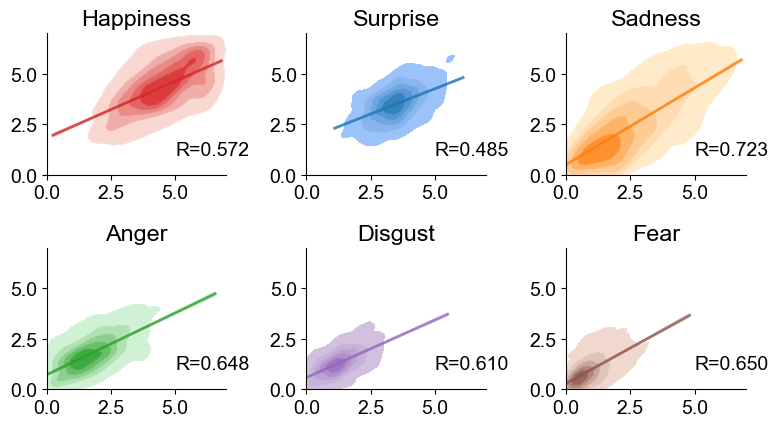

In [ ]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
gradients = [
    LinearSegmentedColormap.from_list('grad1', ['#FFF0E9', colors[0]]),  # Red
    LinearSegmentedColormap.from_list('grad2', ['#A6C8FF', colors[1]]),  # Blue
    LinearSegmentedColormap.from_list('grad3', ['#FFF1D6', colors[2]]),  # Orange
    LinearSegmentedColormap.from_list('grad4', ['#E0F9E4', colors[3]]),  # Green
    LinearSegmentedColormap.from_list('grad5', ['#D5C6E0', colors[4]]),  # Purple
    LinearSegmentedColormap.from_list('grad6', ['#F5E1D7', colors[5]])   # Brown
]

# orange_cmap = LinearSegmentedColormap.from_list('custom orange',['#FFF0E9', '#F48849'])
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 14
plt.figure(figsize=(8,4.5))
for i in range(6):
    # Concatenate preds_smoothed1 and preds_smoothed2 for each emotion
    data = np.concatenate((np.expand_dims(preds_smoothed1[:, i], 1), np.expand_dims(preds_smoothed2[:, i], 1)), 1)
    
    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['x', 'y'])  # Give columns names 'x' and 'y'
    
    ax = plt.subplot(2, 3, i + 1)
    
    # First KDE plot with filled contours
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=True, alpha=1.0, levels=6)
    
    # Second KDE plot without filling and with lines
    sns.kdeplot(data=df, x='x', y='y', cmap=gradients[i], fill=False, levels=6, linewidths=0.5, alpha=0.6)
    
    sns.regplot(data=df, x='x', y='y', scatter=False, line_kws={'color': colors[i], 'lw': 2, 'alpha': 0.8})
    
    plt.title(emos[i])
    plt.xticks(np.arange(0,7,2.5))
    plt.yticks(np.arange(0,7,2.5))
    plt.xlim([0,7])
    plt.ylim([0,7])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(5,1,'R=%.3f' % rs[i])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/inter_group_reliability2.svg', bbox_inches='tight', dpi=300)
plt.show()